## Discretisation

Discretisation is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that span the range of the variable's values. Discretisation is also called **binning**, where bin is an alternative name for interval.


### Discretisation helps handle outliers and may improve value spread in skewed variables

Discretisation helps handle outliers by placing these values into the lower or higher intervals, together with the remaining inlier values of the distribution. Thus, these outlier observations no longer differ from the rest of the values at the tails of the distribution, as they are now all together in the same interval / bucket. In addition, by creating appropriate bins or intervals, discretisation can help spread the values of a skewed variable across a set of bins with equal number of observations.


### Discretisation approaches

There are several approaches to transform continuous variables into discrete ones. Discretisation methods fall into 2 categories: **supervised and unsupervised**. Unsupervised methods do not use any information, other than the variable distribution, to create the contiguous bins in which the values will be placed. Supervised methods typically use target information in order to create the bins or intervals.


####  Unsupervised discretisation methods

- Equal width discretisation
- Equal frequency discretisation
- K-means discretisation

#### Supervised discretisation methods

- Discretisation using decision trees


In this notebook, we will cover **equal width discretisation**.


## Equal width discretisation

Equal width discretisation divides the scope of possible values into N bins of the same width.The width is determined by the range of values in the variable and the number of bins we wish to use to divide the variable:

width = (max value - min value) / N

where N is the number of bins or intervals.

For example if the values of the variable vary between 0 and 100, we create 5 bins like this: width = (100-0) / 5 = 20. The bins thus are 0-20, 20-40, 40-60, 80-100. The first and final bins (0-20 and 80-100) can be expanded to accommodate outliers (that is, values under 0 or greater than 100 would be placed in those bins as well).

There is no rule of thumb to define N, that is something to determine experimentally.

## In this demo

We will learn how to perform equal width binning using the Titanic dataset with

- pandas and NumPy
- Feature-engine
- Scikit-learn

In [1]:
# import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

from feature_engine.discretisation import EqualWidthDiscretiser

In [2]:
# load data

cols = ['age','fare','survived']
data = pd.read_csv('titanic.csv', usecols=cols)
data.head()


,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  1309 non-null   int64  
 1   age       1046 non-null   float64
 2   fare      1308 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 30.8 KB


- We can see there are also some null values in both age and fare variables
- This also needs to be taken care

In [4]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

- Imputing the missing data in age and fare by using random sample imputation

In [5]:
df = X_train['age'].copy()
df

501     13.0000
588      4.0000
402     30.0000
1193        NaN
686     22.0000
         ...   
763      0.1667
835         NaN
1216        NaN
559     20.0000
684     32.0000
Name: age, Length: 916, dtype: float64

In [7]:
random_sample = df.dropna().sample(df.isnull().sum())
random_sample

1276    31.0
551     50.0
572     28.0
316     51.0
323     30.0
        ... 
464     32.0
42      59.0
23      42.0
1224    21.0
823     31.0
Name: age, Length: 175, dtype: float64

In [9]:
# get the index of the random sample with the ones from the missing ones
random_sample.index = df[df.isnull()].index
random_sample.index

Int64Index([1193,  971, 1284, 1027, 1023, 1255, 1114, 1034,  384, 1137,
            ...
            1077, 1262,  802,  882,  976,  705,  277, 1033,  835, 1216],
           dtype='int64', length=175)

In [10]:
# now set the random sample values to the missing variables in df
df.loc[df.isnull()] = random_sample
df.isnull().sum()

0

In [13]:
## lets write a function to perform these

def impute_na(data, variable):

    df= data.copy()
    df[variable + '_random'] = df[variable]
    
    # generate random samples
    samples = df[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
    
    # get the index of the missing observations
    samples.index = df[df[variable].isnull()].index
    
    # set the missing values with the samples
    df.loc[df[variable].isnull(), variable + '_random'] = samples
    
    return df[variable + '_random']

In [14]:
# replace na in both the train and test sets
X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')

X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

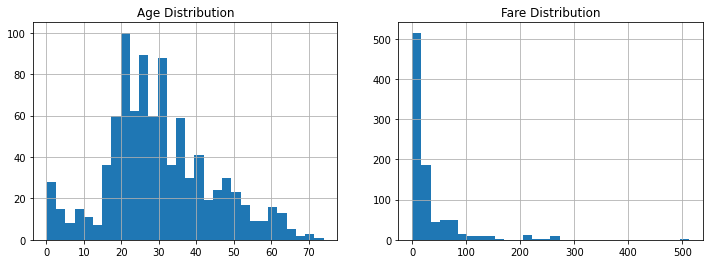

In [19]:
# lets xplore the distribution of age and fare in the original data

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
X_train['age'].hist(bins = 30)
plt.title('Age Distribution')

plt.subplot(1,2,2)
X_train['fare'].hist(bins = 30)
plt.title('Fare Distribution')
plt.show()

## Equal width discretisation with pandas and NumPy

First we need to determine the intervals' edges or limits.

In [20]:
# let's capture the range of the variable age

age_range = X_train['age'].max() - X_train['age'].min()
age_range

73.8333

In [21]:
# dividing it into 8 equal bins
age_range / 8

9.2291625

The range or width of our intervals will be ~9 years.

In [22]:
# now lets capture the lower and upper boundaries

min_value = int(np.floor(X_train['age'].min()))
max_value = int(np.ceil(X_train['age'].max()))

# lets round the bin width
inter_value = int(np.round(age_range/8))

min_value, max_value, inter_value

(0, 74, 9)

In [25]:
# let's capture the interval limits, so we can pass them to the pandas cut 
# function to generate the bins

intervals = [i for i in range(min_value, max_value+inter_value, inter_value)]
intervals

[0, 9, 18, 27, 36, 45, 54, 63, 72, 81]

In [28]:
# lets make labels to label the different bins

labels = ['Bin_'+str(i) for i in range(1,len(intervals))]
labels

['Bin_1',
 'Bin_2',
 'Bin_3',
 'Bin_4',
 'Bin_5',
 'Bin_6',
 'Bin_7',
 'Bin_8',
 'Bin_9']

In [29]:
# create binned age / discretise age

# create one column with labels

X_train['Age_disc_labels'] = pd.cut(x=X_train['age'],
                                    bins=intervals,
                                    labels=labels,
                                    include_lowest=True)

In [30]:
# and one with bin boundaries
X_train['Age_disc'] = pd.cut(x=X_train['age'],
                             bins=intervals,
                             include_lowest=True)

In [31]:
X_train.head(10)

,age,fare,Age_disc_labels,Age_disc
501,13.0,19.5000,Bin_2,"(9.0, 18.0]"
588,4.0,23.0000,Bin_1,"(-0.001, 9.0]"
402,30.0,13.8583,Bin_4,"(27.0, 36.0]"
1193,40.5,7.7250,Bin_5,"(36.0, 45.0]"
686,22.0,7.7250,Bin_3,"(18.0, 27.0]"
971,39.0,7.8792,Bin_5,"(36.0, 45.0]"
117,30.0,56.9292,Bin_4,"(27.0, 36.0]"
540,2.0,26.0000,Bin_1,"(-0.001, 9.0]"
294,49.0,110.8833,Bin_6,"(45.0, 54.0]"
261,35.0,26.2875,Bin_4,"(27.0, 36.0]"


We can see in the above output how by discretising using equal width, we placed each Age observation within one interval / bin. For example, age=13 was placed in the 9-18 interval, whereas age 30 was placed into the 27-36 interval.

When performing equal width discretisation, we guarantee that the intervals are all of the same length, however there won't necessarily be the same number of observations in each of the intervals. See below:

In [32]:
X_train.groupby('Age_disc')['age'].count()

Age_disc
(-0.001, 9.0]     64
(9.0, 18.0]       88
(18.0, 27.0]     279
(27.0, 36.0]     229
(36.0, 45.0]     120
(45.0, 54.0]      78
(54.0, 63.0]      43
(63.0, 72.0]      14
(72.0, 81.0]       1
Name: age, dtype: int64

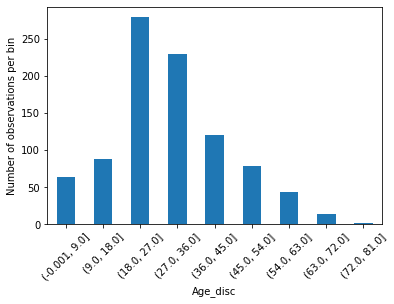

In [34]:
X_train.groupby('Age_disc')['age'].count().plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')
plt.show();

The majority of people on the Titanic were between 18-36 years of age.

Now, we can discretise Age in the test set, using the same interval boundaries that we calculated for the train set:

In [35]:
X_test['Age_disc_labels'] = pd.cut(x=X_test['age'],
                                   bins=intervals,
                                   labels=labels,
                                   include_lowest=True)

X_test['Age_disc'] = pd.cut(x=X_test['age'],
                            bins=intervals,
                            include_lowest=True)

X_test.head()

,age,fare,Age_disc_labels,Age_disc
1139,38.0,7.8958,Bin_5,"(36.0, 45.0]"
533,21.0,21.0000,Bin_3,"(18.0, 27.0]"
459,42.0,27.0000,Bin_5,"(36.0, 45.0]"
1150,35.0,14.5000,Bin_4,"(27.0, 36.0]"
393,25.0,31.5000,Bin_3,"(18.0, 27.0]"


In [36]:
X_train.groupby(['Age_disc'])['age'].count() / len(X_train)

Age_disc
(-0.001, 9.0]    0.069869
(9.0, 18.0]      0.096070
(18.0, 27.0]     0.304585
(27.0, 36.0]     0.250000
(36.0, 45.0]     0.131004
(45.0, 54.0]     0.085153
(54.0, 63.0]     0.046943
(63.0, 72.0]     0.015284
(72.0, 81.0]     0.001092
Name: age, dtype: float64

In [37]:
X_test.groupby(['Age_disc'])['age'].count() / len(X_train)

Age_disc
(-0.001, 9.0]    0.042576
(9.0, 18.0]      0.054585
(18.0, 27.0]     0.122271
(27.0, 36.0]     0.091703
(36.0, 45.0]     0.046943
(45.0, 54.0]     0.036026
(54.0, 63.0]     0.026201
(63.0, 72.0]     0.006550
(72.0, 81.0]     0.002183
Name: age, dtype: float64

Text(0, 0.5, 'Number of observations per bin')

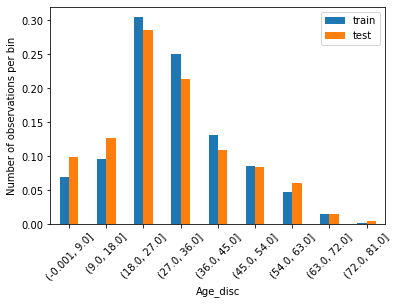

In [38]:
# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set
# let's see that below

t1 = X_train.groupby(['Age_disc'])['age'].count() / len(X_train)
t2 = X_test.groupby(['Age_disc'])['age'].count() / len(X_test)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

## Equal width discretisation with Feature-Engine

In [39]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

In [40]:
# replace NA in both  train and test sets

X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

In [41]:
# with feature engine we can automate the process for many variables
# in one line of code

disc = EqualWidthDiscretiser(bins=8, variables = ['age', 'fare'])

disc.fit(X_train)

EqualWidthDiscretiser(bins=8, variables=['age', 'fare'])

In [42]:
# in the binner dict, we can see the limits of the intervals. For age
# the value increases aproximately 9 years from one bin to the next.

# for fare it increases in around 60-70 dollars from one interval to the 
# next, but it increases always the same value, aka, same width.

disc.binner_dict_

{'age': [-inf,
  10.1458625,
  20.125024999999997,
  30.104187499999995,
  40.083349999999996,
  50.0625125,
  60.04167499999999,
  70.0208375,
  inf],
 'fare': [-inf,
  64.04115,
  128.0823,
  192.12345,
  256.1646,
  320.20575,
  384.2469,
  448.28805,
  inf]}

In [43]:
# transform train and text

train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

In [44]:
train_t.head()

,age,fare
501,1,0
588,0,0
402,2,0
1193,2,0
686,2,0


Text(0, 0.5, 'Number of observations per bin')

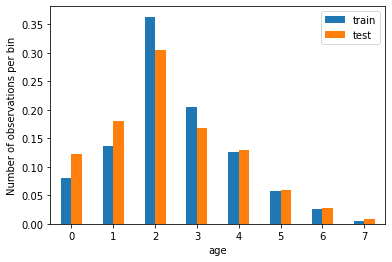

In [45]:
t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

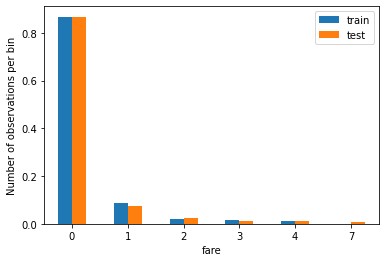

In [46]:
t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

We can see quite clearly, that equal width discretisation does not improve the value spread. The original variable Fare was skewed, and the discrete variable is also skewed.

## Equal width discretisation with Scikit-learn

In [47]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

In [48]:
# replace NA in both  train and test sets

X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')

X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

In [49]:
disc = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform') # uniform for being equal width
disc.fit(X_train[['age', 'fare']])

KBinsDiscretizer(encode='ordinal', n_bins=8, strategy='uniform')

In [50]:
disc.bin_edges_

array([array([ 0.1667   , 10.1458625, 20.125025 , 30.1041875, 40.08335  ,
              50.0625125, 60.041675 , 70.0208375, 80.       ])           ,
       array([  0.     ,  64.04115, 128.0823 , 192.12345, 256.1646 , 320.20575,
              384.2469 , 448.28805, 512.3292 ])                                ],
      dtype=object)

In [51]:
train_t = disc.transform(X_train[['age', 'fare']])

train_t = pd.DataFrame(train_t, columns = ['age', 'fare'])

train_t.head()

,age,fare
0,1.0,0.0
1,0.0,0.0
2,2.0,0.0
3,2.0,0.0
4,2.0,0.0


In [53]:
test_t = disc.transform(X_test[['age', 'fare']])

# since sklearn returns numpy array
test_t = pd.DataFrame(test_t, columns = ['age', 'fare'])

Text(0, 0.5, 'Number of observations per bin')

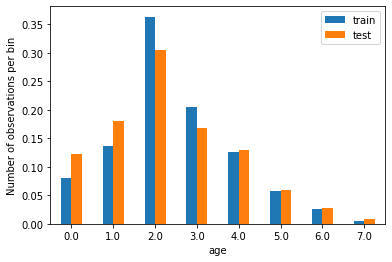

In [54]:
t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

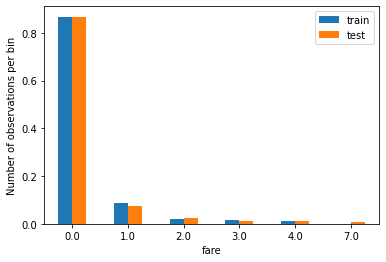

In [55]:
t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')